<a href="https://colab.research.google.com/github/rubeenaafreen20/EE5600AI-ML/blob/master/Speech_Model_Train_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install kapre==0.1.7
%pip install soundfile

  Created wheel for kapre: filename=kapre-0.1.7-cp36-none-any.whl size=11663 sha256=982e63c79229496f07bbaa8da3094bd851649b51dff243fb5a01c8795ef05054
  Stored in directory: /root/.cache/pip/wheels/80/b0/36/f8ef462364784fcb1b7782e73ec59821162318ec28556516b6
Successfully built kapre
  Found existing installation: kapre 0.1.3.1
    Uninstalling kapre-0.1.3.1:
      Successfully uninstalled kapre-0.1.3.1


In [2]:
import os
import numpy as np
import kapre
import librosa
import random
import tensorflow as tf
import soundfile as sf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential,Model
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Generate Data**

In [4]:
data_dir = '/content/drive/My Drive/Aafreen_AIML/Dataset/'
os.chdir(data_dir)

data_x = []
data_y = []
for a,i in enumerate(['back','forward','left','right','stop']):
    lis = os.listdir(data_dir+i)
    for j in lis:
        l,sr = sf.read(data_dir+i+'/'+j)
        #print(len(l))
        #if(len(l)>=8000):
        data_x.append(l[0:8000])
        data_y.append(a)
        #else:
        #    print(i)
    print(i," Done")

data_x = np.array(data_x)
data_y = np.array(data_y)


np.save('x.npy',data_x)
np.save('y.npy',data_y)

back  Done
forward  Done
left  Done
right  Done
stop  Done


# **Splitting Data into Train and Test**

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
np_load_old = np.load

np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

data_x = np.load('x.npy')
data_y = np.load('y.npy')
tr_x,te_x, tr_y,te_y = train_test_split(data_x,data_y,stratify=data_y,random_state=103,test_size=0.4)
np.load = np_load_old

In [19]:
data_x.shape

(400, 8000)

In [7]:

x_train = []
y_train = []
for i,j in enumerate(tr_x):
    x= len(j)
    p = 25000-x
    for y in range(1 ,p, 500):
        nx = np.zeros(25000)
        nx[y:y+x] =j
        x_train.append(nx)
        y_train.append(tr_y[i])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i,j in enumerate(te_x):
    x= len(j)
    p = 25000-x
    for y in range(1 ,p, 500):
        nx = np.zeros(25000)
        nx[y:y+x] =j
        x_test.append(nx)
        y_test.append(te_y[i])
x_test = np.array(x_test)
y_test = np.array(y_test)

np.save('x_train.npy',x_train)
np.save('y_train.npy',y_train)
np.save('x_test.npy',x_test)
np.save('y_test.npy',y_test)

# **Extract Features**

In [8]:
mfcc = Sequential()
mfcc.add(L.Reshape((1, -1)))
mfcc.add(Melspectrogram(padding='same', sr=16000, n_mels=39, n_dft = 1024,
                        power_melgram=2.0, return_decibel_melgram=True,
                        trainable_fb=False, trainable_kernel=False,
                        name='mel_stft'))
mfcc.add(Normalization2D(str_axis='freq'))
mfcc.add(L.Permute((2, 1, 3)))

x_train = mfcc.predict(x_train)
x_train.shape

x_test = mfcc.predict(x_test)
x_test.shape

np.save('mfcc_train.npy',x_train)
np.save('mfcc_test.npy',x_test)

# **Loading Data**

In [9]:
# Change the directory 
data_dir = '/content/drive/My Drive/Aafreen_AIML/Dataset/'
os.chdir(data_dir)
x_train = np.load('mfcc_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('mfcc_test.npy')
y_test = np.load('y_test.npy')

# **Model**

In [10]:
# https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py
os.environ['PYTHONHASHSEED']='123'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

def AttentionModel(sr=16000, iLen=25000):
    
    inputs = L.Input(x_train.shape[1:], name='Input')

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same', name='Conv1')(inputs)
    x = L.BatchNormalization(name='BN1')(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same', name='Conv2')(x)
    x = L.BatchNormalization(name='BN2')(x)

    x = L.Reshape(x.shape[1:-1],name='Squeeze')(x)

    n_units = 64
    x = L.LSTM(n_units, return_sequences=True, name='LSTM_Sequences')(x)  

    # Calculate Unit Importance
    xLast = L.Lambda(lambda q: q[:, -1], name='FinalSequence')(x)  # [b_s, vec_dim]
    xLast = L.Dense(xLast.shape[-1], name='UnitImportance')(xLast)

    # Calculate attention
    attScores = L.Dot(axes=[1, 2],name='AttentionScores')([xLast, x])
    attScores = L.Softmax(name='AttentionSoftmax')(attScores)  

    x = L.Dot(axes=[1, 1], name='AttentionVector')([attScores, x])  
    x = L.Dense(32, activation='relu', name='FC')(x)
    outputs = L.Dense(5, activation='softmax', name='Output')(x)
    model = Model(inputs=[inputs], outputs=[outputs], name='Attention')

    return model

model = AttentionModel()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])


In [11]:
model.summary()

Model: "Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 49, 39, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 49, 39, 10)   60          Input[0][0]                      
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 49, 39, 10)   40          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 49, 39, 1)    51          BN1[0][0]                        
__________________________________________________________________________________________

# **Train Model**

In [12]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=2,epochs=100,shuffle=True,batch_size=20)
#model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=5,shuffle=True,batch_size=20)

Epoch 1/100
544/544 - 4s - loss: 0.1859 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.1686 - val_sparse_categorical_accuracy: 0.9581
Epoch 2/100
544/544 - 3s - loss: 0.0026 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.1764 - val_sparse_categorical_accuracy: 0.9548
Epoch 3/100
544/544 - 3s - loss: 3.1828e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1930 - val_sparse_categorical_accuracy: 0.9533
Epoch 4/100
544/544 - 3s - loss: 1.5461e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2163 - val_sparse_categorical_accuracy: 0.9504
Epoch 5/100
544/544 - 3s - loss: 8.7045e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2052 - val_sparse_categorical_accuracy: 0.9551
Epoch 6/100
544/544 - 3s - loss: 5.4595e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2133 - val_sparse_categorical_accuracy: 0.9548
Epoch 7/100
544/544 - 3s - loss: 3.6085e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2093 - val_sparse_categorical_accuracy: 0.9574
Epoch 8

# **Save Model**

In [13]:
data_dir = '/content/drive/My Drive/Aafreen_AIML/Codes/'
os.chdir(data_dir)
model.save('model.h5') 

# **Check Attention**

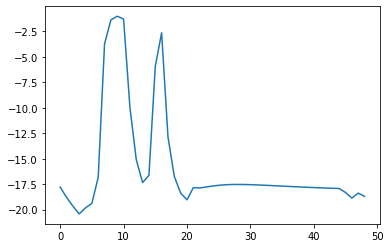

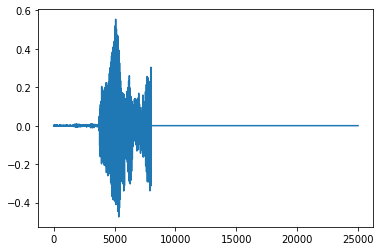

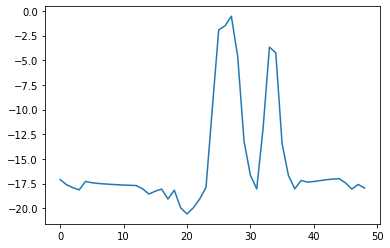

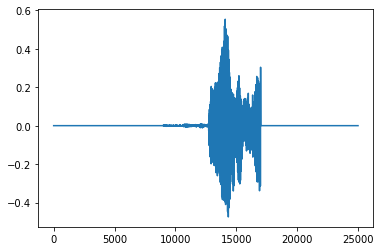

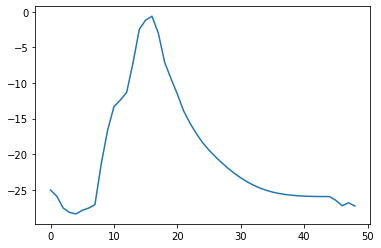

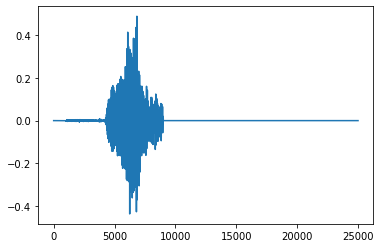

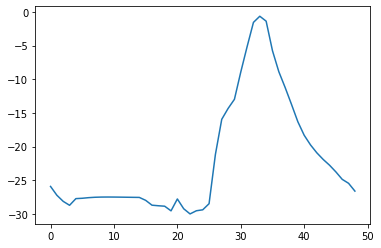

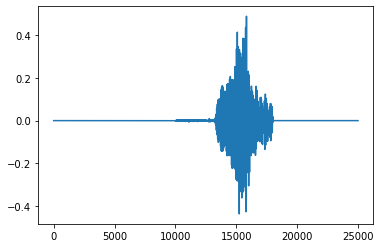

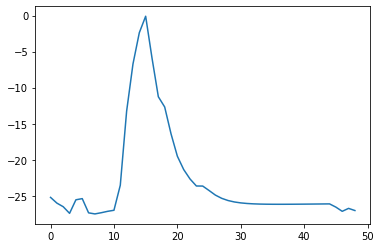

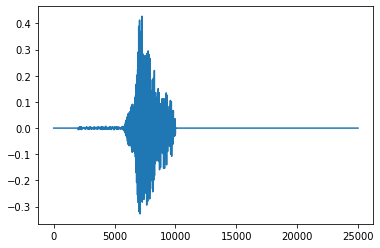

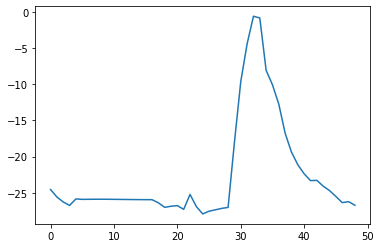

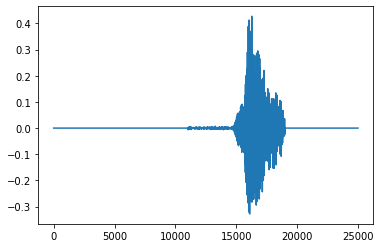

In [14]:
from matplotlib import pyplot as plt
model2 = Model(inputs=model.input, outputs=[model.get_layer('Output').output, 
                                            model.get_layer('AttentionSoftmax').output])
data_dir = '/content/drive/My Drive/Aafreen_AIML/Dataset/'
os.chdir(data_dir)
a,b = model2.predict(x_test)
xx_test = np.load('x_test.npy')
for aid in range(0,100,18):
    plt.plot(range(len(b[aid])), np.log(b[aid]))
    plt.show()
    plt.plot(range(len(xx_test[aid])),xx_test[aid])
    plt.show()

In [15]:
pip install ffmpeg_python

# **Test Model**

In [25]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import ffmpeg
 
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""
 
def record(sec=1, path='audio.wav'):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  process = (ffmpeg
    .input('pipe:0')
    .output(path, format='wav', ac=1, ar=16000)
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  process.communicate(input=b)

In [26]:
from tensorflow import keras
import soundfile as sf
import numpy as np
 
rootPath = '/content/drive/My Drive/Aafreen_AIML/Codes/'
model = keras.models.load_model(rootPath + '/model.h5')
record(path=rootPath + '/testfile.wav')
l = sf.read(rootPath + '/testfile.wav')[0]
l = l[0:8000]
x = len(l)
p = 25000-x
nx = np.zeros(25000)
for y in range(1 ,p, 500):
    nx[y:y+x] = l
nx = nx.reshape([1, len(nx)])
 
mfcc = Sequential()
mfcc.add(L.Reshape((1, -1)))
mfcc.add(Melspectrogram(padding='same', sr=16000, n_mels=39, n_dft = 1024,
                        power_melgram=2.0, return_decibel_melgram=True,
                        trainable_fb=False, trainable_kernel=False,
                        name='mel_stft'))
mfcc.add(Normalization2D(str_axis='freq'))
mfcc.add(L.Permute((2, 1, 3)))
 
nx = mfcc.predict(nx) 
y = model.predict(nx)[0]
y = np.argmax(y)
words = ['back','forward', 'left', 'right', 'stop']
print (words [y])

<IPython.core.display.Javascript object>

forward
